In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import numpy as np

In [2]:
data = pd.read_csv("./local_data/data_cleaned.csv")

In [3]:
data.columns[data.columns.str.startswith("review_")]

Index(['review_scores_cleanliness', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value'],
      dtype='object')

In [4]:
X_raw = data.drop("price", errors="ignore", axis=1).drop(
    [
        "review_scores_cleanliness",
        "review_scores_accuracy",
        "review_scores_checkin",
        "review_scores_communication",
        "review_scores_location",
        "review_scores_value",
    ],
    axis=1,
    errors="ignore",
)
y = data["price"]

In [5]:
skew_by_col = X_raw.skew().abs().sort_values(ascending=False)
skew_by_col[skew_by_col > 1].head(20)

minimum_minimum_nights                          19.719576
minimum_nights                                  18.991228
maximum_maximum_nights                          17.638736
maximum_nights_avg_ntm                          17.638662
minimum_nights_avg_ntm                          17.474660
calculated_host_listings_count_shared_rooms     17.175993
neighbourhood_cleansed__City                    13.285415
neighbourhood_cleansed__Schwamendingen-Mitte    12.412314
room_type__Shared room                          12.412314
neighbourhood_cleansed__Hochschulen              9.146770
neighbourhood_cleansed__Hirzenbach               8.691415
neighbourhood_cleansed__Lindenhof                8.553441
neighbourhood_cleansed__Escher Wyss              7.735483
beds                                             7.597227
neighbourhood_cleansed__Fluntern                 7.539686
maximum_minimum_nights                           7.195868
neighbourhood_cleansed__Witikon                  6.803804
neighbourhood_

In [6]:
skew_threshold = 1.0
# Initialize transformation lists
bool_cols = []
log_transform_cols = []
yeo_johnson_cols = []
scale_cols = []

# First pass: Identify column types and apply transformations
for col in X_raw.columns:
    # Skip if all values are the same
    if X_raw[col].nunique() <= 1:
        continue

    # Check if boolean (1/0)
    elif set(X_raw[col].unique()).issubset({0, 1, np.nan}):
        bool_cols.append(col)

    # Check if transformation needed
    elif abs(X_raw[col].skew()) > skew_threshold:
        # Try log transformation first (adding small constant to handle zeros)
        eps = 1e-6
        log_transformed = np.log(X_raw[col] - X_raw[col].min() + eps)

        # Compare original vs log-transformed skewness
        original_skew = abs(X_raw[col].skew())
        log_skew = abs(log_transformed.skew())

        if log_skew < original_skew:
            log_transform_cols.append(col)
        else:
            yeo_johnson_cols.append(col)

    else:
        scale_cols.append(col)

In [7]:
# Create copy for transformations
X_raw_transformed = X_raw.copy()

# 1. Apply Yeo-Johnson transformation
pt = PowerTransformer(method="yeo-johnson")
if yeo_johnson_cols:
    X_raw_transformed[yeo_johnson_cols] = pt.fit_transform(X_raw[yeo_johnson_cols])

# 2. Apply log transformation (using log1p which handles zeros better than log)
if log_transform_cols:
    scaler = StandardScaler()
    X_raw_transformed[log_transform_cols] = scaler.fit_transform(
        np.log1p(X_raw[log_transform_cols])
    )

# 3. Apply standard scaling
if scale_cols:
    scaler = StandardScaler()
    X_raw_transformed[scale_cols] = scaler.fit_transform(X_raw[scale_cols])

# Boolean columns remain unchanged

In [8]:
assert len(log_transform_cols) + len(scale_cols) + len(bool_cols) + len(
    yeo_johnson_cols
) == len(X_raw.columns)

In [9]:
X_raw_transformed.skew().abs().sort_values(ascending=False).head(50)

neighbourhood_cleansed__City                    13.285415
calculated_host_listings_count_shared_rooms     13.224878
neighbourhood_cleansed__Schwamendingen-Mitte    12.412314
room_type__Shared room                          12.412314
neighbourhood_cleansed__Hochschulen              9.146770
neighbourhood_cleansed__Hirzenbach               8.691415
neighbourhood_cleansed__Lindenhof                8.553441
neighbourhood_cleansed__Escher Wyss              7.735483
neighbourhood_cleansed__Fluntern                 7.539686
neighbourhood_cleansed__Witikon                  6.803804
neighbourhood_cleansed__Albisrieden              6.733838
host_has_profile_pic                             6.733838
neighbourhood_group_cleansed__Kreis 12           6.665820
neighbourhood_cleansed__Hirslanden               6.665820
neighbourhood_cleansed__Friesenberg              6.599661
neighbourhood_cleansed__Werd                     6.472582
neighbourhood_cleansed__Affoltern                6.182081
neighbourhood_

In [10]:
X_raw_transformed.mean().sort_values(ascending=False).head(50)

host_has_profile_pic                      0.979283
host_identity_verified                    0.960159
has_kitchen                               0.796414
room_type__Entire home/apt                0.769323
has_wifi                                  0.753386
has_essentials                            0.709960
has_hot_water                             0.687649
has_hair_dryer                            0.668127
has_dishes_and_silverware                 0.626295
has_refrigerator                          0.623904
has_cooking_basics                        0.617131
has_hangers                               0.609960
has_bed_linens                            0.590040
has_iron                                  0.582869
host_response_time__within an hour        0.538247
has_dedicated_workspace                   0.525100
has_heating                               0.515538
has_shampoo                               0.479283
has_self_check-in                         0.458566
has_long_term_stays_allowed    

In [11]:
X = X_raw_transformed

## RF


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=99
)


# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train
X_test_scaled = X_test

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)
cv = KFold(n_splits=5, shuffle=True, random_state=99)

train Metrics:
R² Score: 0.8284
MSE: 6225.99
RMSE: 78.90
MAE: 32.05
test Metrics:
R² Score: 0.4754
MSE: 17080.30
RMSE: 130.69
MAE: 59.15


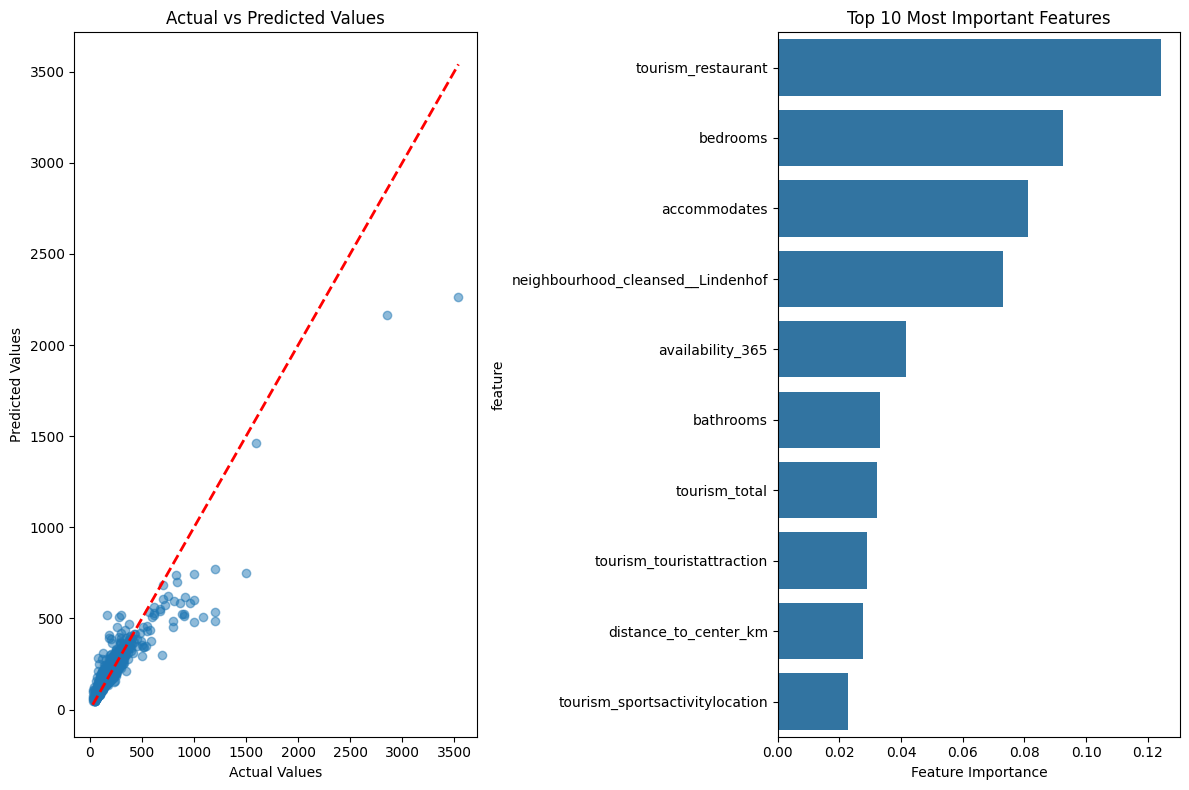

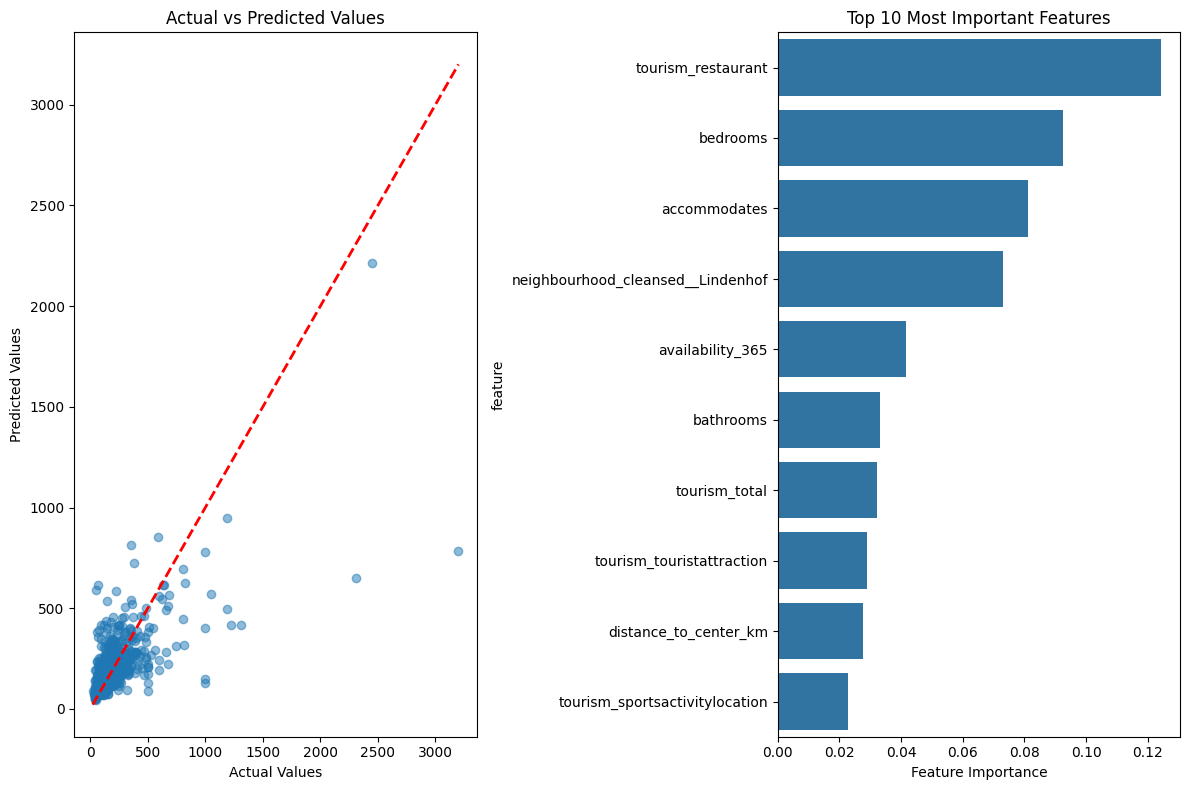

In [13]:
# # find best parameters for random forest
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# rf = RandomForestRegressor()

# param_dist = {
#     "n_estimators": randint(100, 500),
#     "max_depth": [None, 10, 20, 30],
#     "min_samples_split": randint(2, 20),
#     "min_samples_leaf": randint(1, 10),
# }

# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_dist,
#     n_iter=15,
#     cv=5,
#     scoring="neg_mean_squared_error",
#     n_jobs=-1,
#     random_state=99,
# )
# # random_search.fit(X_train, y_train)

# print("Best Parameters:", random_search.best_params_)
# print("Best Score:", random_search.best_score_)

# Random Forest functions


def perform_rf(X_train_scaled, y_train):  # use best parameters in regressor
    rf = RandomForestRegressor(
        n_estimators=155,
        random_state=99,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
    )

    rf.fit(X_train_scaled, y_train)

    return rf


def evaluate_rf(rf, y_true, y_pred, dataset_name: str):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{dataset_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

    feature_importance = pd.DataFrame(
        {"feature": X.columns, "importance": rf.feature_importances_}
    ).sort_values(by="importance", ascending=False)

    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "feature_importance": feature_importance,
    }


def visualize_rf_performance(y_true, y_pred, feature_importance):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    # Scatter, actual vs predicted
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", lw=2
    )
    axes[0].set_title("Actual vs Predicted Values")
    axes[0].set_xlabel("Actual Values")
    axes[0].set_ylabel("Predicted Values")

    # feature_importance bar chart (top 10)

    top_features = feature_importance.head(10)
    sns.barplot(x="importance", y="feature", data=top_features, ax=axes[1])
    axes[1].set_title("Top 10 Most Important Features")
    axes[1].set_xlabel("Feature Importance")

    plt.tight_layout()
    plt.show()


# perform Random forest and evaluate

rf = perform_rf(X_train_scaled, y_train)  # fit random forest model

y_train_pred_rf = rf.predict(X_train_scaled)  # make predictions
y_test_pred_rf = rf.predict(X_test_scaled)

dict_rf1 = evaluate_rf(
    rf, y_train, y_train_pred_rf, "train"
)  # evaluate with MSE etc. and show most important features

dict_rf2 = evaluate_rf(rf, y_test, y_test_pred_rf, "test")

visualize_rf_performance(
    y_train, y_train_pred_rf, dict_rf1["feature_importance"]
)  # create scatter plot with actual vs predicted data, plot bar chart with most important features

visualize_rf_performance(y_test, y_test_pred_rf, dict_rf2["feature_importance"])

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=99
)

# Define cross-validation strategy.
cv = KFold(n_splits=5, shuffle=True, random_state=99)

# Create a pipeline that scales the data and then applies LassoCV.
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "lasso_cv",
            LassoCV(
                cv=cv,
                random_state=99,
                max_iter=100000,
                alphas=np.logspace(-4, 3, 200),
                selection="random",
                tol=1e-3,
                fit_intercept=True,
            ),
        ),
    ]
)

# Fit the pipeline on the training data.
pipeline.fit(X_train, y_train)

# Access the fitted LassoCV model from the pipeline.
lasso_cv = pipeline.named_steps["lasso_cv"]

NameError: name 'y_transformed' is not defined

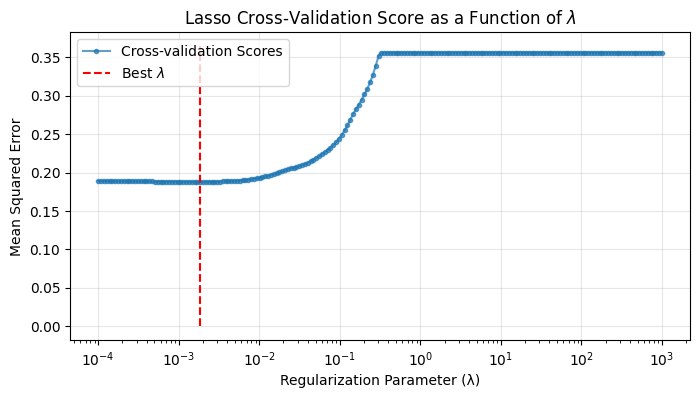

Best regularization parameter: 0.00

Training Metrics:
R² Score: 0.3795
RMSE: 148.20
MAE: 60.13

Testing Metrics:
R² Score: 0.1982
RMSE: 156.03
MAE: 52.60


In [33]:
# Plot the cross-validation results.
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(
    lasso_cv.alphas_,
    lasso_cv.mse_path_.mean(axis=1),
    marker="o",
    markersize=3,
    alpha=0.7,
    label="Cross-validation Scores",
)

# Plot the selected regularization parameter.
ax.vlines(
    lasso_cv.alpha_,
    ymin=0,
    ymax=ax.get_ylim()[1],
    linestyle="--",
    color="red",
    label=r"Best $\lambda$",
)

# Customize the plot.
ax.set_xscale("log")
ax.set_xlabel("Regularization Parameter (λ)")
ax.set_ylabel("Mean Squared Error")
ax.set_title(r"Lasso Cross-Validation Score as a Function of $\lambda$")
ax.grid(alpha=0.3)
ax.legend()
plt.show()

print(f"Best regularization parameter: {lasso_cv.alpha_:.2f}")


# Define a function to evaluate the model.
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray, dataset_name: str) -> None:
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{dataset_name.capitalize()} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")


# Make predictions on the training and testing sets.
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Evaluate the model on the training set.
evaluate_model(np.exp(y_train), np.exp(y_train_pred), "training")

# Evaluate the model on the testing set.
evaluate_model(np.exp(y_test), np.exp(y_test_pred), "testing")

\coeffs:
                                             feat     coeff
6                                    accommodates  0.174693
18                                  amenity_count  0.127521
11                 tourism_sportsactivitylocation  0.110709
38                                  has_hot_water -0.102406
63                               bathrooms_shared -0.095987
34                                       bedrooms  0.094399
20                              number_of_reviews -0.075812
5                    tourism_points_within_radius -0.073528
9                                   tourism_hotel  0.069721
37                          number_of_reviews_ltm -0.069600
70          neighbourhood_group_cleansed__Kreis 1  0.066344
30                            review_scores_value -0.060491
10                                      bathrooms  0.056787
7                       host_total_listings_count -0.054270
0                              tourism_restaurant  0.054047
17                           ho

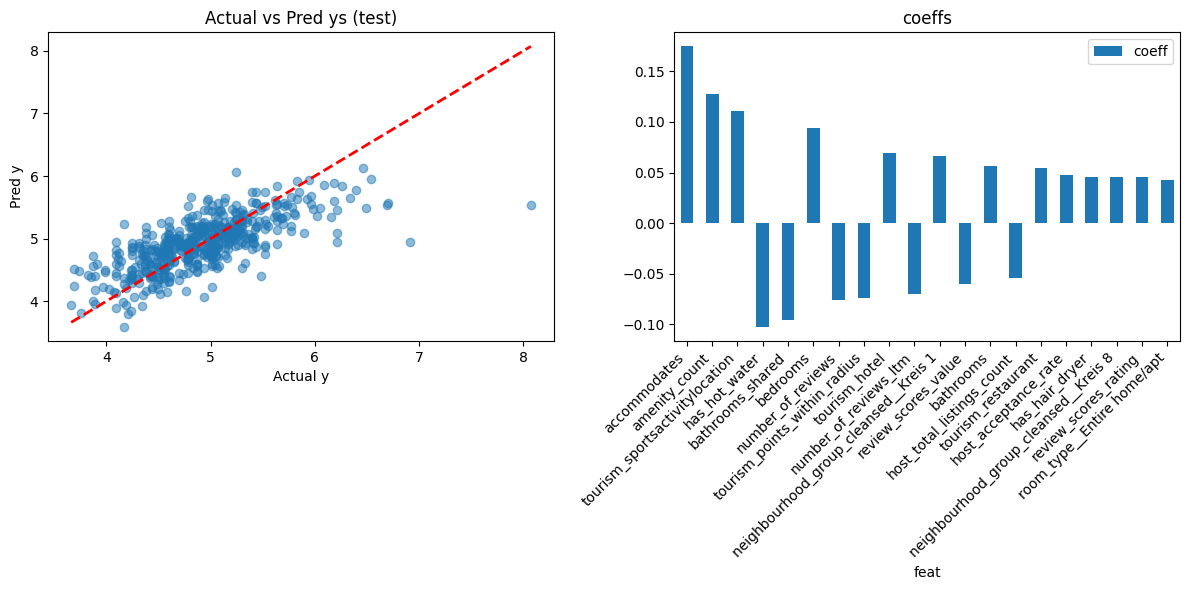

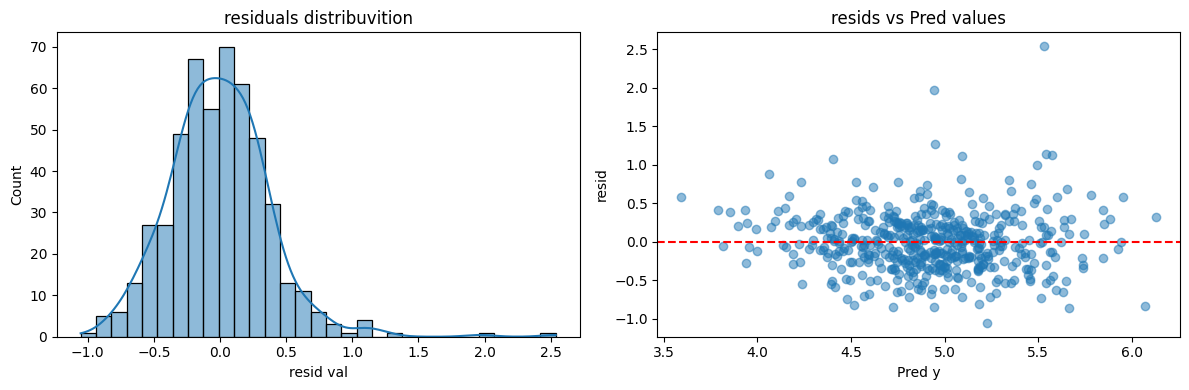

In [34]:
feature_importance = pd.DataFrame({"feat": X.columns, "coeff": lasso_cv.coef_})

feature_importance["Abs_coeff"] = abs(feature_importance["coeff"])
feature_importance_sorted = feature_importance.sort_values("Abs_coeff", ascending=False)
non_zero_features = feature_importance_sorted[feature_importance_sorted["coeff"] != 0]

print(r"\coeffs:")
print(non_zero_features[["feat", "coeff"]].to_string())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual y")
plt.ylabel("Pred y")
plt.title("Actual vs Pred ys (test)")

# Plot 2: feat coeffs
plt.subplot(1, 2, 2)
non_zero_features.head(20).plot(kind="bar", x="feat", y="coeff", ax=plt.gca())
plt.xticks(rotation=45, ha="right")
plt.title("coeffs")
plt.tight_layout()
plt.show()

residuals = y_test - y_test_pred

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("residuals distribuvition")
plt.xlabel("resid val")

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Pred y")
plt.ylabel("resid")
plt.title("resids vs Pred values")
plt.tight_layout()
plt.show()

In [35]:
coefficient_df = pd.DataFrame(
    {
        "feature": X.columns,
        "coeff": lasso_cv.coef_,
        "coeff_abs": abs(lasso_cv.coef_),
    }
)

coefficient_df = coefficient_df.sort_values("coeff_abs", ascending=False)
coefficient_df

,feature,coeff,coeff_abs
6,accommodates,0.174693,0.174693
18,amenity_count,0.127521,0.127521
11,tourism_sportsactivitylocation,0.110709,0.110709
38,has_hot_water,-0.102406,0.102406
63,bathrooms_shared,-0.095987,0.095987
...,...,...,...
3,tourism_total,0.000000,0.000000
13,tourism_touristattraction,-0.000000,0.000000
4,noise_night,-0.000000,0.000000
8,noise_day,-0.000000,0.000000


## RF


In [36]:
# find best parameters for random forest
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf = RandomForestRegressor()

param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=15,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=99,
)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Random Forest functions


def perform_rf(X_train_scaled, y_train):  # use best parameters in regressor
    rf = RandomForestRegressor(
        n_estimators=155,
        random_state=99,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
    )

    rf.fit(X_train_scaled, y_train)

    return rf


def evaluate_rf(rf, y_true, y_pred, dataset_name: str):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{dataset_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

    feature_importance = pd.DataFrame(
        {"feature": X.columns, "importance": rf.feature_importances_}
    ).sort_values(by="importance", ascending=False)

    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "feature_importance": feature_importance,
    }


def visualize_rf_performance(y_true, y_pred, feature_importance):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    # Scatter, actual vs predicted
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", lw=2
    )
    axes[0].set_title("Actual vs Predicted Values")
    axes[0].set_xlabel("Actual Values")
    axes[0].set_ylabel("Predicted Values")

    # feature_importance bar chart (top 10)

    top_features = feature_importance.head(10)
    sns.barplot(x="importance", y="feature", data=top_features, ax=axes[1])
    axes[1].set_title("Top 10 Most Important Features")
    axes[1].set_xlabel("Feature Importance")

    plt.tight_layout()
    plt.show()


# perform Random forest and evaluate

rf = perform_rf(X_train_scaled, y_train)  # fit random forest model

y_train_pred_rf = rf.predict(X_train_scaled)  # make predictions
y_test_pred_rf = rf.predict(X_test_scaled)

dict_rf1 = evaluate_rf(
    rf, y_train, y_train_pred_rf, "train"
)  # evaluate with MSE etc. and show most important features

dict_rf2 = evaluate_rf(rf, y_test, y_test_pred_rf, "test")

visualize_rf_performance(
    y_train, y_train_pred_rf, dict_rf1["feature_importance"]
)  # create scatter plot with actual vs predicted data, plot bar chart with most important features

visualize_rf_performance(y_test, y_test_pred_rf, dict_rf2["feature_importance"])

Best Parameters: {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 297}
Best Score: -0.1659936734121547


NameError: name 'X_train_scaled' is not defined

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Parameters: {'bootstrap': False, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 833}
Best CV Score (RMSE): 0.4099

Training Metrics:
R² Score: 0.8577
RMSE: 0.2250
MAE: 0.1481

Test Metrics:
R² Score: 0.5691
RMSE: 0.3605
MAE: 0.2484


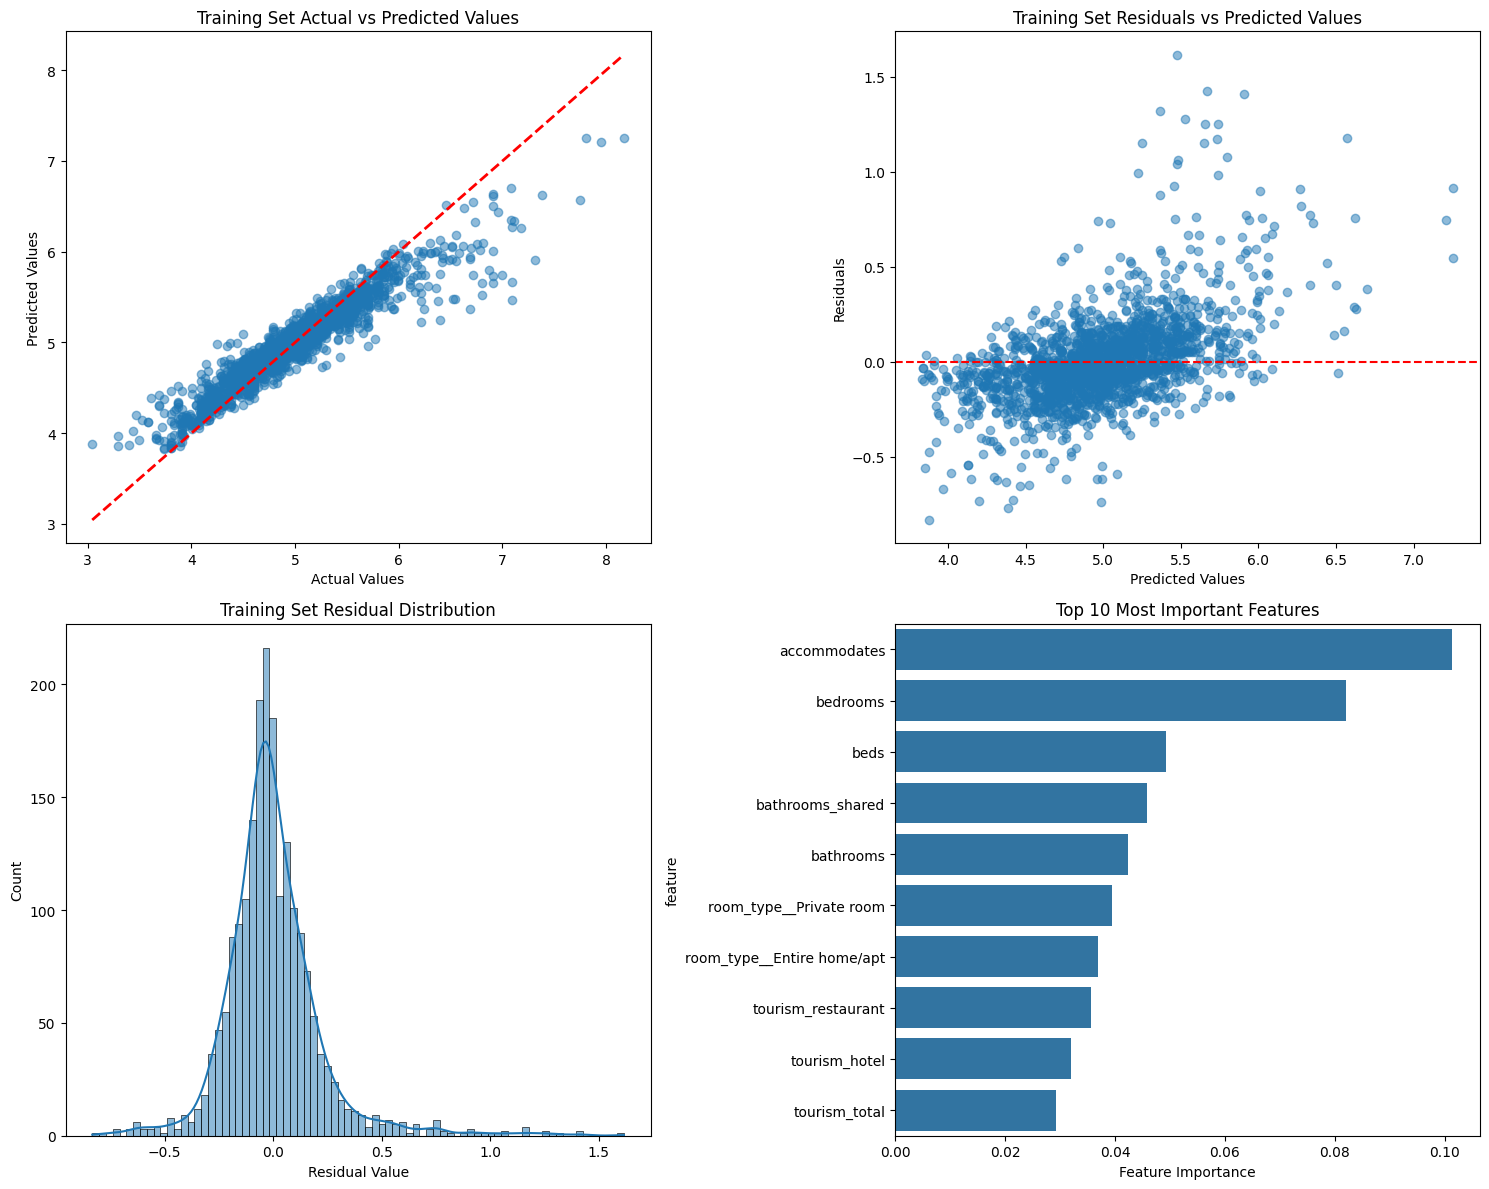

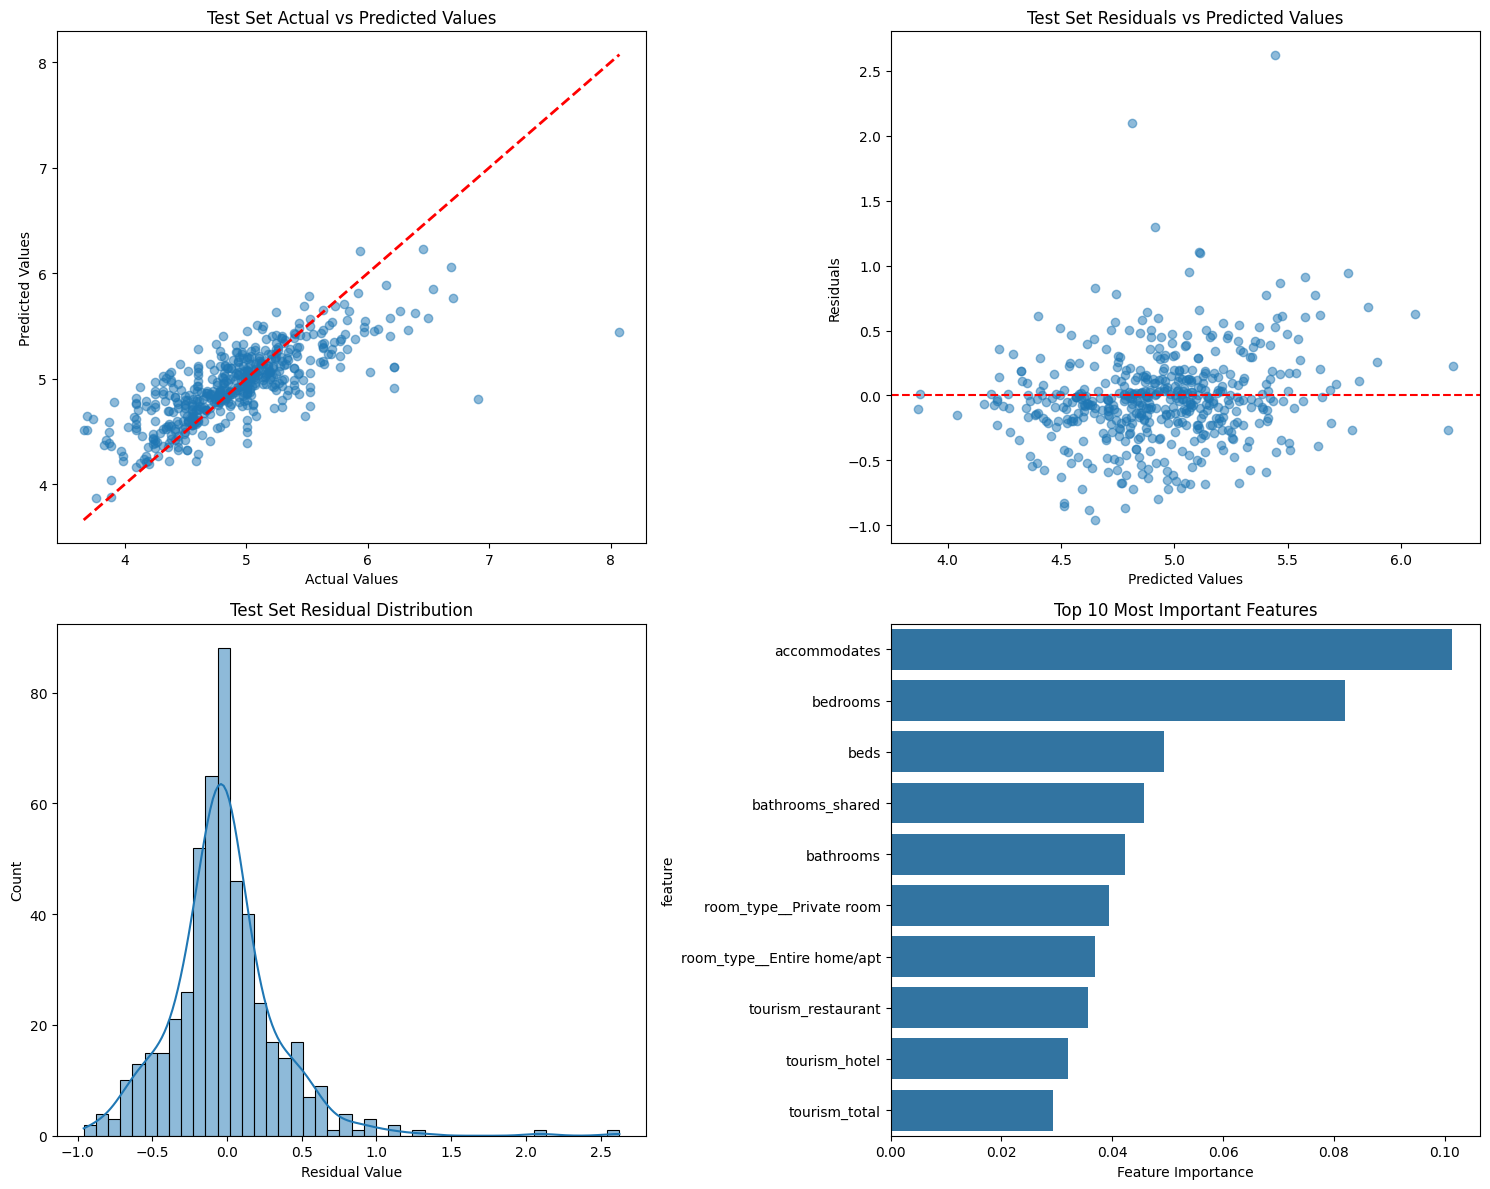

In [37]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint
import warnings

warnings.filterwarnings("ignore")

# Define hyperparameter search space
param_dist = {
    "n_estimators": randint(100, 1000),
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": randint(2, 30),
    "min_samples_leaf": randint(1, 15),
    "max_features": ["auto", "sqrt"],
    "bootstrap": [True, False],
}

# Perform hyperparameter search
rf = RandomForestRegressor(random_state=99)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=99,
    verbose=1,
)

# Fit the random search
random_search.fit(X_train, y_train)

# Print results
print("\nBest Parameters:", random_search.best_params_)
print(f"Best CV Score (RMSE): {(-random_search.best_score_)**0.5:.4f}")

# Train final model with best parameters
best_rf = RandomForestRegressor(**random_search.best_params_, random_state=99)
best_rf.fit(X_train, y_train)

# Make predictions
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Calculate feature importance
feature_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": best_rf.feature_importances_}
).sort_values("importance", ascending=False)


# Function for model evaluation
def evaluate_model(y_true, y_pred, dataset_name=""):
    """Evaluate model performance with multiple metrics"""
    metrics = {
        "r2": r2_score(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "mae": mean_absolute_error(y_true, y_pred),
    }

    print(f"\n{dataset_name} Metrics:")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")

    return metrics


# Evaluate on train and test sets
train_metrics = evaluate_model(y_train, y_train_pred, "Training")
test_metrics = evaluate_model(y_test, y_test_pred, "Test")


# Function for diagnostic plots
def plot_diagnostics(y_true, y_pred, feature_importance, title_prefix=""):
    """Create diagnostic plots for model performance"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Actual vs Predicted
    axes[0, 0].scatter(y_true, y_pred, alpha=0.5)
    axes[0, 0].plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", lw=2
    )
    axes[0, 0].set_title(f"{title_prefix} Actual vs Predicted Values")
    axes[0, 0].set_xlabel("Actual Values")
    axes[0, 0].set_ylabel("Predicted Values")

    # Residuals
    residuals = y_true - y_pred
    axes[0, 1].scatter(y_pred, residuals, alpha=0.5)
    axes[0, 1].axhline(y=0, color="r", linestyle="--")
    axes[0, 1].set_title(f"{title_prefix} Residuals vs Predicted Values")
    axes[0, 1].set_xlabel("Predicted Values")
    axes[0, 1].set_ylabel("Residuals")

    # Residual Distribution
    sns.histplot(residuals, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title(f"{title_prefix} Residual Distribution")
    axes[1, 0].set_xlabel("Residual Value")

    # Feature Importance
    top_features = feature_importance.head(10)
    sns.barplot(x="importance", y="feature", data=top_features, ax=axes[1, 1])
    axes[1, 1].set_title("Top 10 Most Important Features")
    axes[1, 1].set_xlabel("Feature Importance")

    plt.tight_layout()
    return fig, axes


# Create diagnostic plots for training set
plot_diagnostics(y_train, y_train_pred, feature_importance, "Training Set")

# Create diagnostic plots for test set
plot_diagnostics(y_test, y_test_pred, feature_importance, "Test Set")

Performing hyperparameter search...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Parameters: {'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__min_samples_split': 3, 'randomforestregressor__n_estimators': 226}
Best CV Score (RMSE): 138.3070

Training Metrics:
R² Score: 0.8315
RMSE: 77.2291
MAE: 33.7652

Testing Metrics:
R² Score: 0.2585
RMSE: 150.0522
MAE: 53.7348


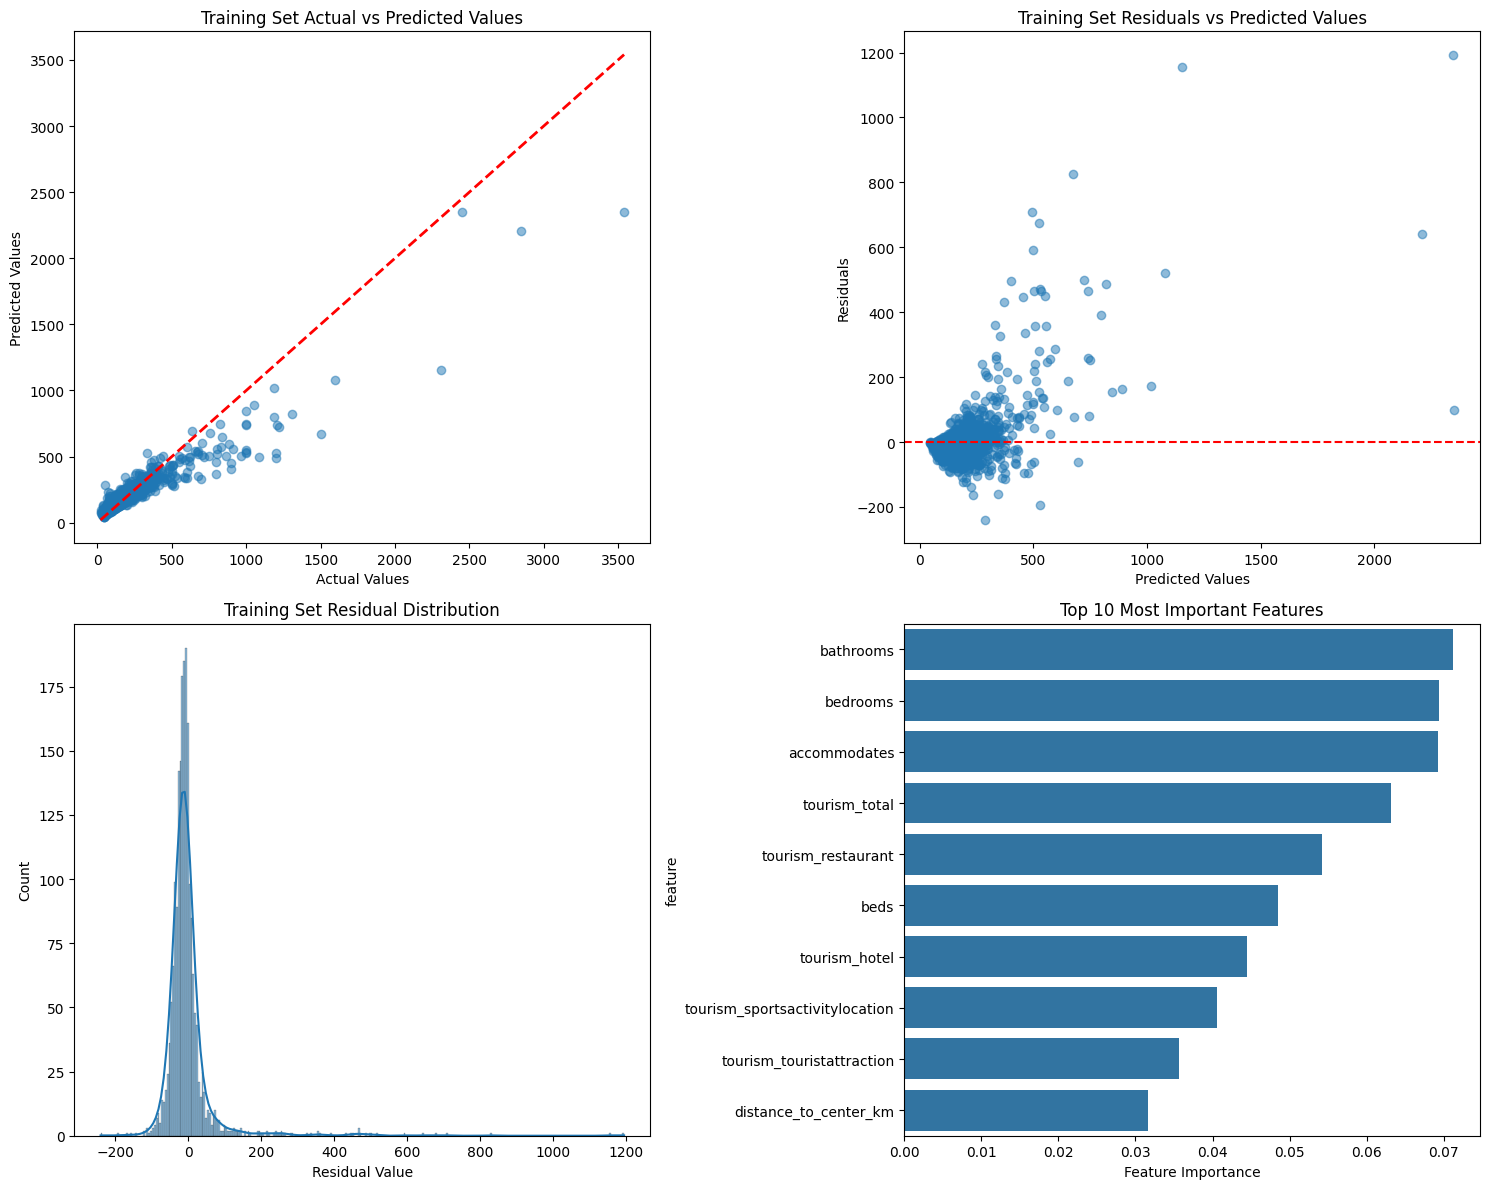

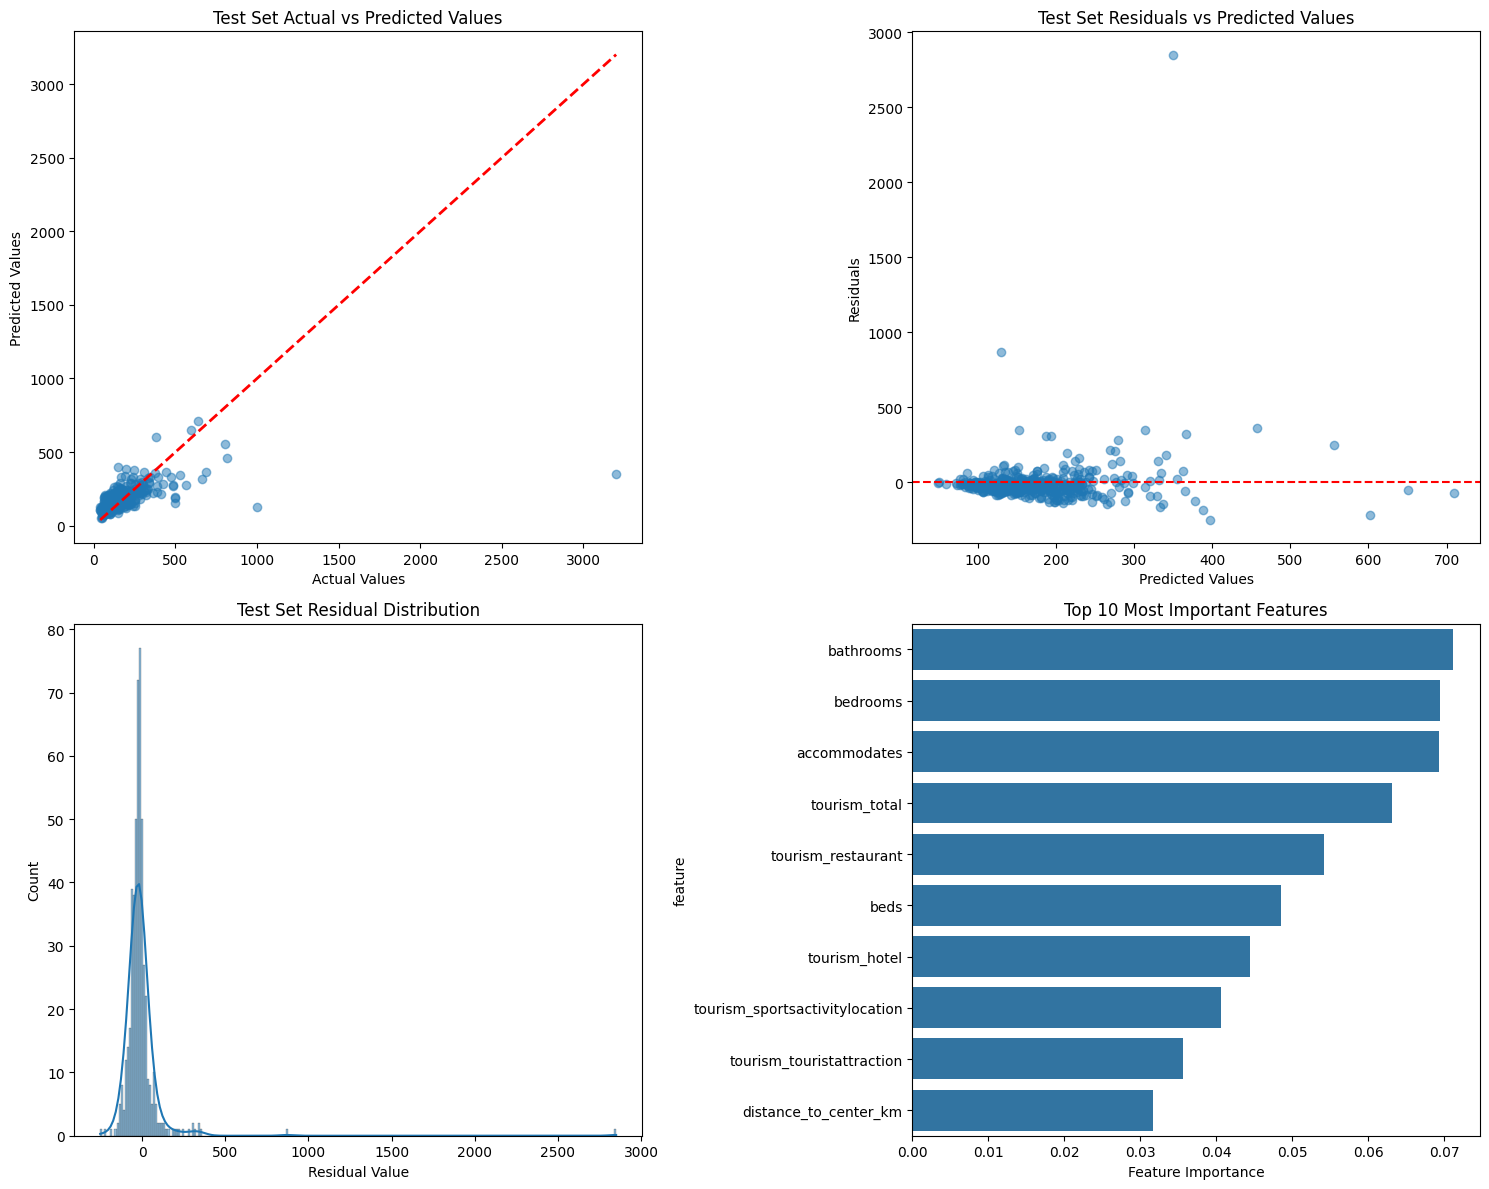


Top 10 Most Important Features:
                           feature  importance
10                       bathrooms    0.071121
28                        bedrooms    0.069391
6                     accommodates    0.069236
3                    tourism_total    0.063144
0               tourism_restaurant    0.054150
15                            beds    0.048430
9                    tourism_hotel    0.044414
11  tourism_sportsactivitylocation    0.040601
13       tourism_touristattraction    0.035611
2            distance_to_center_km    0.031611


In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=99
)

# Define cross-validation strategy.
cv = KFold(n_splits=5, shuffle=True, random_state=99)

# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    "randomforestregressor__n_estimators": randint(50, 500),
    "randomforestregressor__max_depth": [None, 5, 10, 20, 30, 40, 50],
    "randomforestregressor__min_samples_split": randint(2, 30),
    "randomforestregressor__min_samples_leaf": randint(1, 15),
    "randomforestregressor__max_features": ["auto", "sqrt"],
    "randomforestregressor__bootstrap": [True, False],
}

# Create a pipeline that scales the data and then applies RandomForest
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "randomforestregressor",
            RandomForestRegressor(
                random_state=99,
            ),
        ),
    ]
)

# Create RandomizedSearchCV with the pipeline
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=99,
    verbose=1,
)

# Fit RandomizedSearchCV
print("Performing hyperparameter search...")
random_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest Parameters:", random_search.best_params_)
print(f"Best CV Score (RMSE): {(-random_search.best_score_)**0.5:.4f}")

# Get the best pipeline
best_pipeline = random_search.best_estimator_

# Access the fitted RandomForestRegressor from the pipeline
rf_model = best_pipeline.named_steps["randomforestregressor"]


def evaluate_model(pipeline, X, y, dataset_name=""):
    """Evaluate model performance and return metrics"""
    y_pred = pipeline.predict(X)

    metrics = {
        "r2": r2_score(y, y_pred),
        "mse": mean_squared_error(y, y_pred),
        "rmse": np.sqrt(mean_squared_error(y, y_pred)),
        "mae": mean_absolute_error(y, y_pred),
    }

    print(f"\n{dataset_name} Metrics:")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")

    return metrics, y_pred


def plot_results(y_true, y_pred, feature_importance, dataset_name=""):
    """Create visualization plots"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Actual vs Predicted
    axes[0, 0].scatter(y_true, y_pred, alpha=0.5)
    axes[0, 0].plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", lw=2
    )
    axes[0, 0].set_title(f"{dataset_name} Actual vs Predicted Values")
    axes[0, 0].set_xlabel("Actual Values")
    axes[0, 0].set_ylabel("Predicted Values")

    # Residuals vs Predicted
    residuals = y_true - y_pred
    axes[0, 1].scatter(y_pred, residuals, alpha=0.5)
    axes[0, 1].axhline(y=0, color="r", linestyle="--")
    axes[0, 1].set_title(f"{dataset_name} Residuals vs Predicted Values")
    axes[0, 1].set_xlabel("Predicted Values")
    axes[0, 1].set_ylabel("Residuals")

    # Residual Distribution
    sns.histplot(residuals, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title(f"{dataset_name} Residual Distribution")
    axes[1, 0].set_xlabel("Residual Value")

    # Feature Importance
    importance_df = (
        pd.DataFrame({"feature": X.columns, "importance": feature_importance})
        .sort_values("importance", ascending=False)
        .head(10)
    )

    sns.barplot(x="importance", y="feature", data=importance_df, ax=axes[1, 1])
    axes[1, 1].set_title("Top 10 Most Important Features")
    axes[1, 1].set_xlabel("Feature Importance")

    plt.tight_layout()
    plt.show()


# Evaluate model performance
train_metrics, y_train_pred = evaluate_model(
    best_pipeline, X_train, y_train, "Training"
)
test_metrics, y_test_pred = evaluate_model(best_pipeline, X_test, y_test, "Testing")

# Plot results
plot_results(y_train, y_train_pred, rf_model.feature_importances_, "Training Set")
plot_results(y_test, y_test_pred, rf_model.feature_importances_, "Test Set")

# Save feature importance
feature_importance_df = pd.DataFrame(
    {"feature": X.columns, "importance": rf_model.feature_importances_}
).sort_values("importance", ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))

In [60]:
# Log transform the target variable since price is right-skewed
y = np.log1p(data["price"])  # Transform before train_test_split
# Don't forget to transform back when evaluating:
y_pred_transformed = np.expm1(y_pred)

param_distributions = {
    "randomforestregressor__n_estimators": randint(100, 300),
    "randomforestregressor__max_depth": [5, 8, 10, 12, 15],  # Reduced max_depth options
    "randomforestregressor__min_samples_split": randint(5, 20),  # Increased min_samples
    "randomforestregressor__min_samples_leaf": randint(
        5, 20
    ),  # Increased min_samples_leaf
    "randomforestregressor__max_features": ["sqrt", "log2"],  # Removed 'auto'
    "randomforestregressor__bootstrap": [True],
}

from sklearn.feature_selection import SelectFromModel

pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("feature_selection", SelectFromModel(RandomForestRegressor(random_state=99))),
        ("randomforestregressor", RandomForestRegressor(random_state=99)),
    ]
)


def remove_price_outliers(X, y, threshold=3):
    # Calculate z-score of prices
    z_scores = np.abs((y - y.mean()) / y.std())
    # Keep only non-outlier data
    mask = z_scores < threshold
    return X[mask], y[mask]


X_cleaned, y_cleaned = remove_price_outliers(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=99
)

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    cv=cv,
    scoring=["neg_mean_squared_error", "r2", "neg_mean_absolute_error"],
    refit="neg_mean_squared_error",
    n_jobs=-1,
    random_state=99,
    verbose=1,
)


def engineer_features(X):
    X = X.copy()

    # Price per person potential
    X["price_per_accommodates"] = X["price"] / X["accommodates"]

    # Amenity score
    amenity_columns = [col for col in X.columns if col.startswith("has_")]
    X["amenity_score"] = X[amenity_columns].sum(axis=1)

    # Review score average
    review_columns = [col for col in X.columns if col.startswith("review_scores_")]
    X["avg_review_score"] = X[review_columns].mean(axis=1)

    # Location score
    X["location_score"] = X["tourism_total"] / (X["distance_to_center_km"] + 1)

    return X


X = engineer_features(X_raw)

from sklearn.model_selection import cross_val_score


def evaluate_model(pipeline, X, y, dataset_name=""):
    """Evaluate model performance with cross-validation"""
    # Get cross-validation scores
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring="r2")

    # Get predictions
    y_pred = pipeline.predict(X)

    metrics = {
        "r2": r2_score(y, y_pred),
        "rmse": np.sqrt(mean_squared_error(y, y_pred)),
        "mae": mean_absolute_error(y, y_pred),
        "cv_r2_mean": cv_scores.mean(),
        "cv_r2_std": cv_scores.std(),
    }

    print(f"\n{dataset_name} Metrics:")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(
        f"CV R² Score: {metrics['cv_r2_mean']:.4f} (+/- {metrics['cv_r2_std']*2:.4f})"
    )

    return metrics, y_pred


pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "feature_selection",
            SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=99)),
        ),
        (
            "randomforestregressor",
            RandomForestRegressor(
                random_state=99,
                oob_score=True,  # Enable out-of-bag score
                max_samples=0.8,  # Use only 80% of samples for each tree
            ),
        ),
    ]
)

NameError: name 'y_pred' is not defined

In [61]:
import numpy as np
import pandas as pd
from sklearn.model_selection import (
    train_test_split,
    KFold,
    RandomizedSearchCV,
    cross_val_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint


def evaluate_model(pipeline, X, y, dataset_name=""):
    """
    Evaluate model performance with multiple metrics
    """
    # Get cross-validation scores
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring="r2")

    # Get predictions
    y_pred = pipeline.predict(X)

    # Transform back if using log-transformed target
    y_true = np.expm1(y)
    y_pred = np.expm1(y_pred)

    metrics = {
        "r2": r2_score(y_true, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "mae": mean_absolute_error(y_true, y_pred),
        "cv_r2_mean": cv_scores.mean(),
        "cv_r2_std": cv_scores.std(),
    }

    print(f"\n{dataset_name} Metrics:")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(
        f"CV R² Score: {metrics['cv_r2_mean']:.4f} (+/- {metrics['cv_r2_std']*2:.4f})"
    )

    return metrics, y_pred


def plot_results(y_true, y_pred, feature_importance, X_columns, dataset_name=""):
    """
    Create visualization plots for model evaluation
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Actual vs Predicted
    axes[0, 0].scatter(y_true, y_pred, alpha=0.5)
    axes[0, 0].plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", lw=2
    )
    axes[0, 0].set_title(f"{dataset_name} Actual vs Predicted Values")
    axes[0, 0].set_xlabel("Actual Values")
    axes[0, 0].set_ylabel("Predicted Values")

    # Residuals vs Predicted
    residuals = y_true - y_pred
    axes[0, 1].scatter(y_pred, residuals, alpha=0.5)
    axes[0, 1].axhline(y=0, color="r", linestyle="--")
    axes[0, 1].set_title(f"{dataset_name} Residuals vs Predicted Values")
    axes[0, 1].set_xlabel("Predicted Values")
    axes[0, 1].set_ylabel("Residuals")

    # Residual Distribution
    sns.histplot(residuals, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title(f"{dataset_name} Residual Distribution")
    axes[1, 0].set_xlabel("Residual Value")

    # Feature Importance
    importance_df = (
        pd.DataFrame({"feature": X_columns, "importance": feature_importance})
        .sort_values("importance", ascending=False)
        .head(10)
    )

    sns.barplot(x="importance", y="feature", data=importance_df, ax=axes[1, 1])
    axes[1, 1].set_title("Top 10 Most Important Features")
    axes[1, 1].set_xlabel("Feature Importance")

    plt.tight_layout()
    plt.show()

In [62]:
y = np.log1p(data["price"])  # Log transform the target variable

Performing hyperparameter search...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Parameters: {'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 12, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__min_samples_split': 13, 'randomforestregressor__n_estimators': 127}
Best CV Score (RMSE): 0.4205

Training Metrics:
R² Score: 0.4435
RMSE: 140.3433
MAE: 49.1355
CV R² Score: 0.4938 (+/- 0.0941)

Testing Metrics:
R² Score: 0.2231
RMSE: 153.5893
MAE: 50.1602
CV R² Score: 0.4361 (+/- 0.1083)


ValueError: array must not contain infs or NaNs

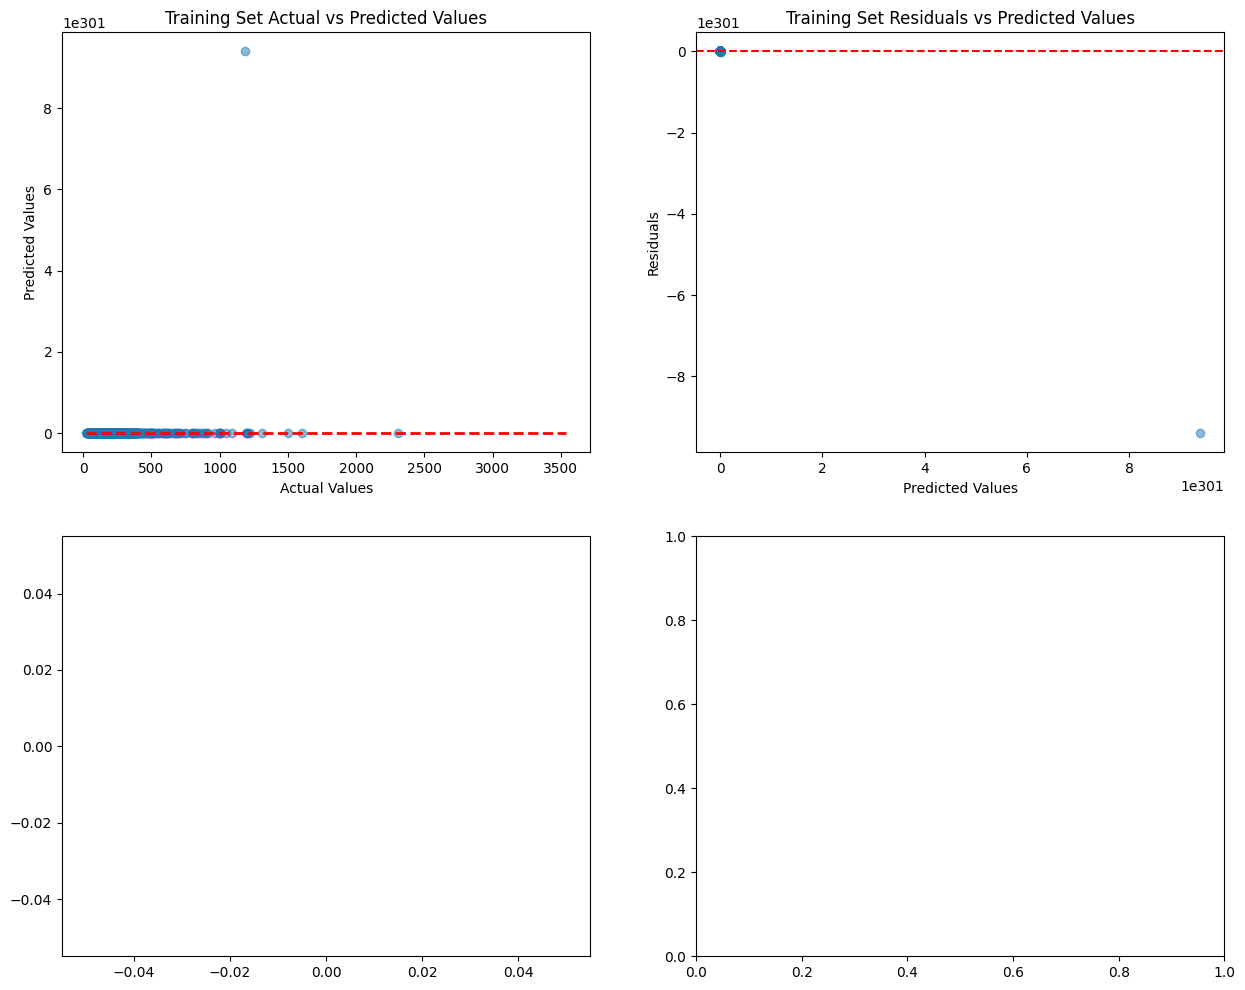

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=99
)

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=99)

# Define parameter distributions
param_distributions = {
    "randomforestregressor__n_estimators": randint(100, 300),
    "randomforestregressor__max_depth": [5, 8, 10, 12, 15],
    "randomforestregressor__min_samples_split": randint(5, 20),
    "randomforestregressor__min_samples_leaf": randint(5, 20),
    "randomforestregressor__max_features": ["sqrt", "log2"],
    "randomforestregressor__bootstrap": [True],
}

# Create pipeline
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "feature_selection",
            SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=99)),
        ),
        (
            "randomforestregressor",
            RandomForestRegressor(random_state=99, oob_score=True, max_samples=0.8),
        ),
    ]
)

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    cv=cv,
    scoring=["neg_mean_squared_error", "r2", "neg_mean_absolute_error"],
    refit="neg_mean_squared_error",
    n_jobs=-1,
    random_state=99,
    verbose=1,
)

# Fit RandomizedSearchCV
print("Performing hyperparameter search...")
random_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest Parameters:", random_search.best_params_)
print(f"Best CV Score (RMSE): {(-random_search.best_score_)**0.5:.4f}")

# Get best pipeline
best_pipeline = random_search.best_estimator_
rf_model = best_pipeline.named_steps["randomforestregressor"]

# Evaluate model
train_metrics, y_train_pred = evaluate_model(
    best_pipeline, X_train, y_train, "Training"
)
test_metrics, y_test_pred = evaluate_model(best_pipeline, X_test, y_test, "Testing")

# Plot results
plot_results(
    np.expm1(y_train),
    np.expm1(y_train_pred),
    rf_model.feature_importances_,
    X.columns,
    "Training Set",
)
plot_results(
    np.expm1(y_test),
    np.expm1(y_test_pred),
    rf_model.feature_importances_,
    X.columns,
    "Test Set",
)

# Print feature importance
feature_importance_df = pd.DataFrame(
    {"feature": X.columns, "importance": rf_model.feature_importances_}
).sort_values("importance", ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))